In [14]:
import pandas as pd
import numpy as np

# Generate weekly dates
dates = pd.date_range(start="2020-01-05", end="2022-06-26", freq="W")

np.random.seed(42)

data = []

for i, date in enumerate(dates):

    # Smooth increasing trend
    trend = 150 + (i * 1.2)   # higher slope = more positive trend

    # Strong summer seasonal effect (June–Aug)
    month = date.month
    if month in [6, 7, 8]:
        seasonal = 180
    elif month in [4, 5, 9]:
        seasonal = 90
    else:
        seasonal = 25

    # Noise
    noise = np.random.normal(0, 25)

    total_orders = max(10, trend + seasonal + noise)

    data.append([date, int(total_orders)])

df_synthetic = pd.DataFrame(data, columns=["order_date", "total_orders"])

# Add a moderate spike (+15%)
last_value = df_synthetic.iloc[-1]["total_orders"]
next_week_value = int(last_value * 1.15)

next_week_date = df_synthetic.iloc[-1]["order_date"] + pd.Timedelta(weeks=1)
df_next_week = pd.DataFrame([[next_week_date, next_week_value]],
                            columns=["order_date","total_orders"])

df_orders = pd.concat([df_synthetic, df_next_week], ignore_index=True)

df_orders

,order_date,total_orders
0,2020-01-05,187
1,2020-01-12,172
2,2020-01-19,193
3,2020-01-26,216
4,2020-02-02,173
...,...,...
126,2022-06-05,456
127,2022-06-12,468
128,2022-06-19,486
129,2022-06-26,472


In [15]:
import pandas as pd

# Ensure 'order_date' is datetime type and set it as the index for resampling
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])
df_orders.set_index('order_date', inplace=True)

# Aggregate total orders by week
df_orders_weekly = df_orders.resample('W').sum().reset_index()

df_orders_weekly = df_orders_weekly.drop(df_orders_weekly.index[-1])

print(df_orders)

            total_orders
order_date              
2020-01-05           187
2020-01-12           172
2020-01-19           193
2020-01-26           216
2020-02-02           173
...                  ...
2022-06-05           456
2022-06-12           468
2022-06-19           486
2022-06-26           472
2022-07-03           542

[131 rows x 1 columns]


In [16]:
df_orders_weekly = df_orders_weekly.iloc[:-5]
print(df_orders_weekly)

    order_date  total_orders
0   2020-01-05           187
1   2020-01-12           172
2   2020-01-19           193
3   2020-01-26           216
4   2020-02-02           173
..         ...           ...
120 2022-04-24           403
121 2022-05-01           362
122 2022-05-08           421
123 2022-05-15           352
124 2022-05-22           403

[125 rows x 2 columns]


In [17]:
df_orders_weekly.to_csv("orders_weekly.csv",index=False)

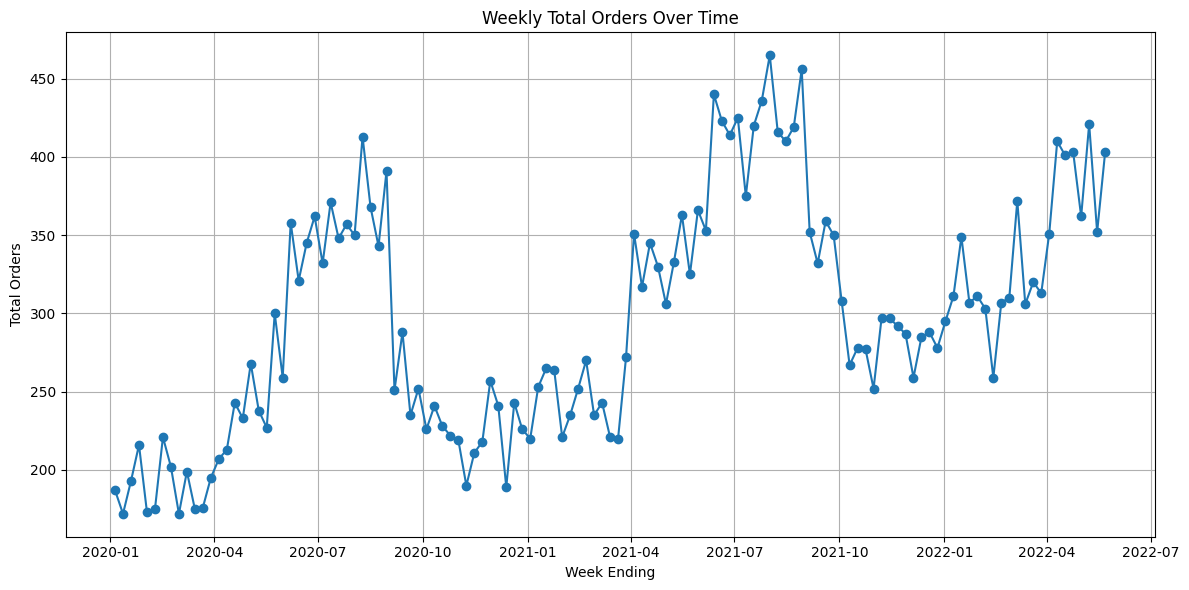

In [18]:
import matplotlib.pyplot as plt

# Plot line graph
plt.figure(figsize=(12,6))
plt.plot(df_orders_weekly['order_date'], df_orders_weekly['total_orders'], marker='o')
plt.title('Weekly Total Orders Over Time')
plt.xlabel('Week Ending')
plt.ylabel('Total Orders')
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_

Best Params: Trend=None, Seasonal=add, Seasonal Periods=51
Average MAPE of best model: 6.28%


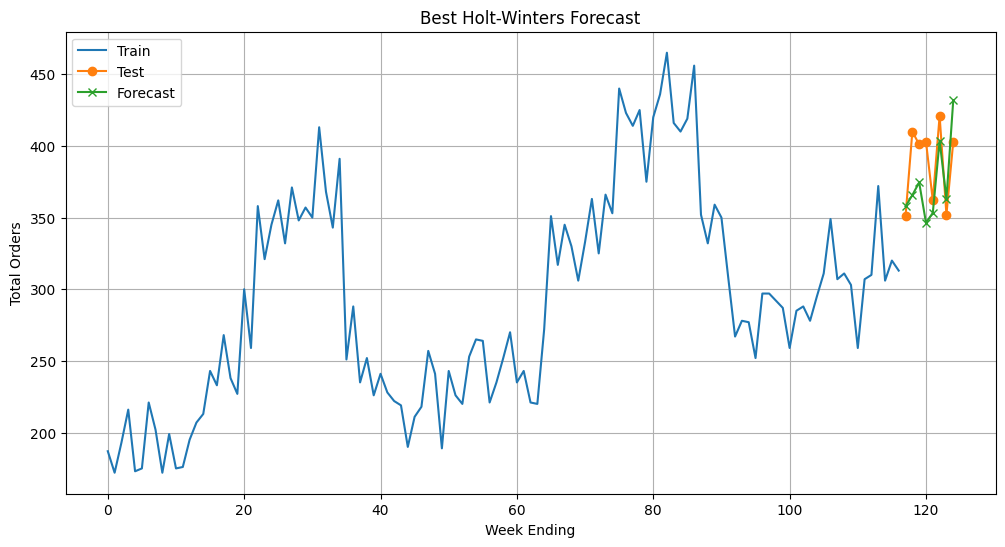

In [19]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

# Prepare data
train_series = df_orders_weekly['total_orders'][:-8]
test_series = df_orders_weekly['total_orders'][-8:]

# Hyperparameter grid
trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
seasonal_periods_options = list(range(4, 53))  # 4 to 52 weeks

best_mape = np.inf
best_params = None
best_forecast = None

# Rolling cross-validation
for trend in trend_options:
    for seasonal in seasonal_options:
        if seasonal is None and trend is None:
            continue  # need at least one component
        for sp in seasonal_periods_options:
            if seasonal is None:
                sp_val = None
            else:
                sp_val = sp
            try:
                # Fit model on train_series
                model = ExponentialSmoothing(
                    train_series,
                    trend=trend,
                    seasonal=seasonal,
                    seasonal_periods=sp_val
                ).fit()

                # Forecast next 8 weeks
                forecast = model.forecast(8)

                # Calculate MAPE
                mape = np.mean(np.abs((test_series - forecast) / test_series)) * 100

                # Update best model
                if mape < best_mape:
                    best_mape = mape
                    best_params = (trend, seasonal, sp_val)
                    best_forecast = forecast

            except:
                continue  # some combinations may fail

print(f"Best Params: Trend={best_params[0]}, Seasonal={best_params[1]}, Seasonal Periods={best_params[2]}")
print(f"Average MAPE of best model: {best_mape:.2f}%")

# Optional: plot best forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train_series.index, train_series, label='Train')
plt.plot(test_series.index, test_series, label='Test', marker='o')
plt.plot(test_series.index, best_forecast, label='Forecast', marker='x')
plt.title('Best Holt-Winters Forecast')
plt.xlabel('Week Ending')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# ==============================
#  STEP 2: TRAIN FINAL MODEL ON FULL DATA
# ==============================

# Extract best params
best_trend, best_seasonal, best_sp = best_params

print("\nTraining final model on FULL dataset using best hyperparameters...")
print(f"Trend: {best_trend}, Seasonal: {best_seasonal}, Seasonal Periods: {best_sp}")

# Fit model on ALL data
final_model = ExponentialSmoothing(
    df_orders_weekly['total_orders'],
    trend=best_trend,
    seasonal=best_seasonal,
    seasonal_periods=best_sp
).fit()

# Compute residuals from full model
fitted_vals_full = final_model.fittedvalues
residuals = df_orders_weekly['total_orders'] - fitted_vals_full

# ==============================
#  STEP 3: BOOTSTRAP FORECASTING
# ==============================

n_simulations = 1000
forecast_horizon = 8

sim_forecasts = []

for _ in range(n_simulations):
    # Sample residuals with replacement
    boot_resid = np.random.choice(residuals, size=forecast_horizon, replace=True)

    # Base forecast + bootstrapped residuals
    forecast_sim = final_model.forecast(forecast_horizon) + boot_resid
    sim_forecasts.append(forecast_sim.values)

sim_forecasts = np.array(sim_forecasts)

# Confidence intervals
lower_95 = np.percentile(sim_forecasts, 2.5, axis=0)
upper_95 = np.percentile(sim_forecasts, 97.5, axis=0)
lower_80 = np.percentile(sim_forecasts, 10, axis=0)
upper_80 = np.percentile(sim_forecasts, 90, axis=0)
median_forecast = np.median(sim_forecasts, axis=0)

# Forecast index
forecast_index = pd.date_range(
    start=df_orders_weekly['order_date'].iloc[-1] + pd.Timedelta(weeks=1),
    periods=forecast_horizon,
    freq="W-MON"
)

# ==============================
#  STEP 4: CREATE FORECAST DATAFRAME
# ==============================

final_forecast_df = pd.DataFrame({
    "Week": forecast_index,
    "Median Forecast": median_forecast,
    "Lower 80%": lower_80,
    "Upper 80%": upper_80,
    "Lower 95%": lower_95,
    "Upper 95%": upper_95
})

print("\nFinal 8-week Bootstrapped Forecast:")
print(final_forecast_df)




Training final model on FULL dataset using best hyperparameters...
Trend: None, Seasonal: add, Seasonal Periods: 51

Final 8-week Bootstrapped Forecast:
        Week  Median Forecast   Lower 80%   Upper 80%   Lower 95%   Upper 95%
0 2022-05-30       411.088352  392.759629  432.067288  376.295001  454.299577
1 2022-06-06       467.030260  447.114532  486.422191  426.780484  515.094584
2 2022-06-13       464.790219  447.044814  487.616166  429.593518  524.510792
3 2022-06-20       444.141924  425.310634  462.212010  404.976586  493.554982
4 2022-06-27       469.076692  449.160965  489.432626  434.572123  517.141017
5 2022-07-04       431.134217  412.595310  452.679310  395.144013  490.061287
6 2022-07-11       455.082643  435.556441  477.722515  417.026983  515.912893
7 2022-07-18       459.043059  440.714336  478.315007  424.348924  519.266198


In [28]:
final_forecast_df.to_csv("forecasted_orders_synthetic_1.csv",index=False)

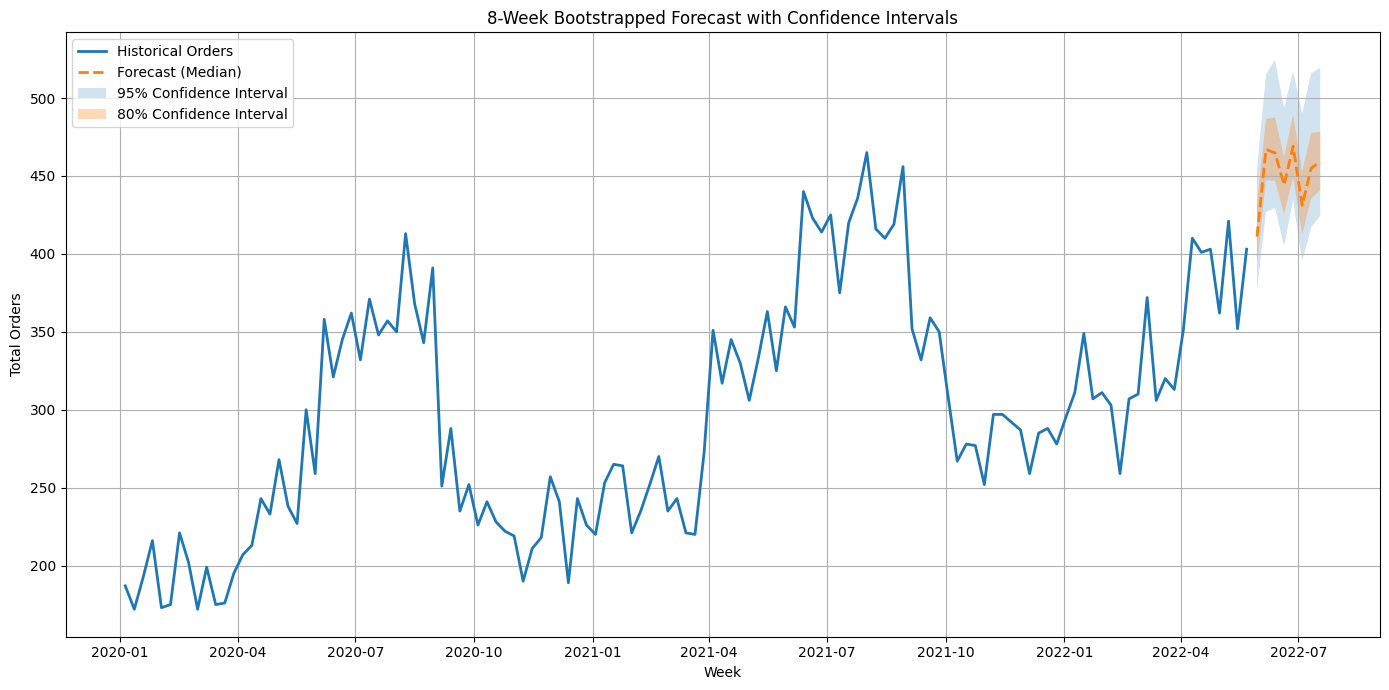

In [22]:
import matplotlib.pyplot as plt

# ============================
# PLOT HISTORICAL + FORECAST
# ============================

plt.figure(figsize=(14, 7))

# Historical data
plt.plot(
    df_orders_weekly["order_date"],
    df_orders_weekly["total_orders"],
    label="Historical Orders",
    linewidth=2
)

# Median forecast
plt.plot(
    final_forecast_df["Week"],
    final_forecast_df["Median Forecast"],
    label="Forecast (Median)",
    linestyle="--",
    linewidth=2
)

# 95% CI shading
plt.fill_between(
    final_forecast_df["Week"],
    final_forecast_df["Lower 95%"],
    final_forecast_df["Upper 95%"],
    alpha=0.2,
    label="95% Confidence Interval"
)

# 80% CI shading
plt.fill_between(
    final_forecast_df["Week"],
    final_forecast_df["Lower 80%"],
    final_forecast_df["Upper 80%"],
    alpha=0.3,
    label="80% Confidence Interval"
)

plt.xlabel("Week")
plt.ylabel("Total Orders")
plt.title("8-Week Bootstrapped Forecast with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
import numpy as np

# Generate weekly dates
dates = pd.date_range(start="2020-01-05", end="2022-06-26", freq="W")

np.random.seed(42)

data = []

for i, date in enumerate(dates):

    # Smooth increasing trend
    trend = 150 + (i * 1.2)   # higher slope = more positive trend

    # Strong summer seasonal effect (June–Aug)
    month = date.month
    if month in [6, 7, 8]:
        seasonal = 180
    elif month in [4, 5, 9]:
        seasonal = 90
    else:
        seasonal = 25

    # Noise
    noise = np.random.normal(0, 25)

    total_orders = max(10, trend + seasonal + noise)

    data.append([date, int(total_orders)])

df_synthetic = pd.DataFrame(data, columns=["order_date", "total_orders"])

# Add a moderate spike (+15%)
last_value = df_synthetic.iloc[-1]["total_orders"]
next_week_value = int(last_value * 1.15)

next_week_date = df_synthetic.iloc[-1]["order_date"] + pd.Timedelta(weeks=1)
df_next_week = pd.DataFrame([[next_week_date, next_week_value]],
                            columns=["order_date","total_orders"])

df_synthetic = pd.concat([df_synthetic, df_next_week], ignore_index=True)

df_synthetic

,order_date,total_orders
0,2020-01-05,187
1,2020-01-12,172
2,2020-01-19,193
3,2020-01-26,216
4,2020-02-02,173
...,...,...
126,2022-06-05,456
127,2022-06-12,468
128,2022-06-19,486
129,2022-06-26,472


In [26]:
df_synthetic.to_csv("synthetic_orders_1.csv")

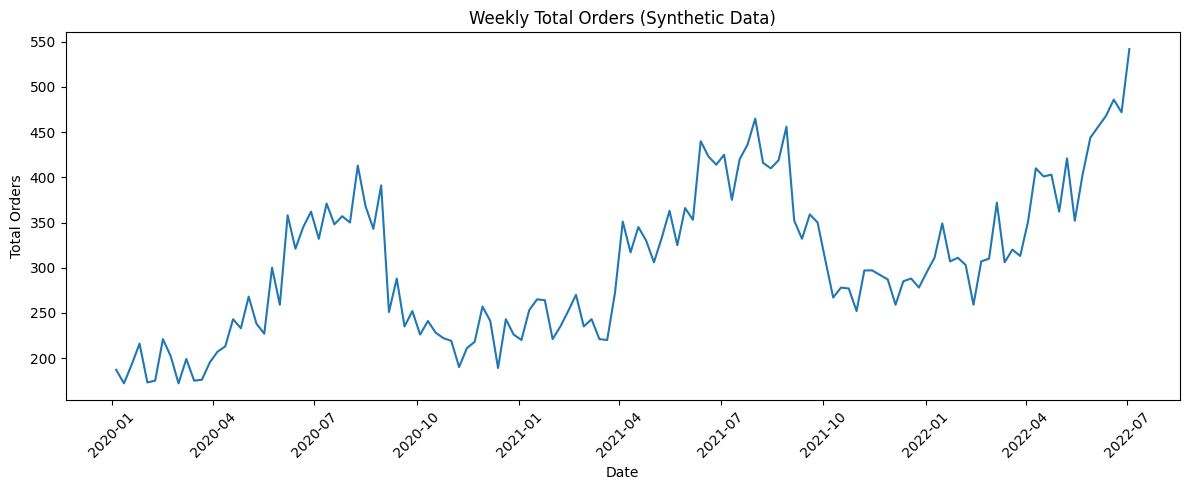

In [25]:
import matplotlib.pyplot as plt

# Plot line graph
plt.figure(figsize=(12, 5))
plt.plot(df_synthetic["order_date"], df_synthetic["total_orders"])

plt.title("Weekly Total Orders (Synthetic Data)")
plt.xlabel("Date")
plt.ylabel("Total Orders")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
